In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os, sys, gc
import pickle

import itertools
import seaborn as sns

os.chdir("/home/fvalle/phd/mouse_Atlas/")
sys.path.append("/home/fvalle/phd/")
sys.path.append("/home/fvalle/phd/master_thesis/")
from tableanalyser import discretize_df_columns, plotvarmen, plotcv2mean, plotoversigmacv2, getovergenes, plotoverpoints
from tacos_plot import scatterdense

In [5]:
# bash gunzip $(ls | grep -e "[a-zA-Z0-9\.\__].gz")
files = os.listdir('data')
#rs = np.random.RandomState(seed=42)
#rs.shuffle(files)

In [6]:
def cleanup():
    os.chdir("data")
    for file in files:
        print(file)
        with open(file, "r") as f:
            data = f.read().replace("\"","")
        with open(file, "w") as f:
            f.write(data)
    os.chdir("../")
    
def load_pickle(filename):
    import pickle
    with open(filename,"rb") as f:
        data = pickle.load(f)
    return data
#cleanup()

In [7]:
df_info = pd.read_csv("MCA_Figure2_Cell.info_V2.csv", index_col=0)
df_info['Cell_id'] = list(map(lambda ann: ann.replace("Adult",""), df_info['Cell_id'])) #remove adult or fetal
df_info['Cell_id'] = list(map(lambda ann: ann.replace("Fetal",""), df_info['Cell_id'])) #remove adult or fetal
df_info.head()

,Cell_barcode,Batch,Cell_id,Cluster_id,Development_stage,Method,Species,tissue,group,Celltype
1,AAAACGAAGCGGCCGCTA,AdultBladder1,Bladder_1.AAAACGAAGCGGCCGCTA,AdultBladder_5,Adult,Microwell-seq,Mouse,AdultBladder,30,Fibroblast
2,AAAACGAAGTACTAGCAT,AdultBladder1,Bladder_1.AAAACGAAGTACTAGCAT,AdultBladder_16,Adult,Microwell-seq,Mouse,AdultBladder,30,Fibroblast
3,AAAACGACGTTGCTGTGT,AdultBladder1,Bladder_1.AAAACGACGTTGCTGTGT,AdultBladder_8,Adult,Microwell-seq,Mouse,AdultBladder,30,Fibroblast
4,AAAACGAGCGAGCGAGTA,AdultBladder1,Bladder_1.AAAACGAGCGAGCGAGTA,AdultBladder_4,Adult,Microwell-seq,Mouse,AdultBladder,30,Fibroblast
5,AAAACGAGGGTCAGATGG,AdultBladder1,Bladder_1.AAAACGAGGGTCAGATGG,AdultBladder_7,Adult,Microwell-seq,Mouse,AdultBladder,30,Fibroblast


In [8]:
#df_file=pd.read_csv("MCA_CellAssignments.csv", index_col=0).set_index('Cell.name')
#df_file['Cell_type'] = list(map(lambda ann: ann.split('(')[0].split(' ')[0], df_file['Annotation'])) #remove adult or fetal
#print(df_file.info())
#print(df_file['Tissue'].unique())
#print(df_file['Cell_type'].unique())
#df_file.head()

In [9]:
df_info.groupby(['Development_stage']).count()

,Cell_barcode,Batch,Cell_id,Cluster_id,Method,Species,tissue,group,Celltype
Development_stage,,,,,,,,,
Adult,45565,45565,45565,45565,45565,45565,45565,45565,45565
E14.5Embryos,1280,1280,1280,1280,1280,1280,1280,1280,1280
Fetal,16212,16212,16212,16212,16212,16212,16212,16212,16212
Neonatal,14220,14220,14220,14220,14220,14220,14220,14220,14220


In [10]:
df_info.groupby(['tissue','Celltype']).count()

Cell_barcode  Batch  Cell_id  \
tissue       Celltype                                                     
AdultBladder Cd8 T cell                              13     13       13   
             Dendritic cell                          39     39       39   
             Endothelial cell                        92     92       92   
             Fibroblast                             904    904      904   
             M2 Macrophage                           39     39       39   
...                                                 ...    ...      ...   
Uterus       Monocyte                                 7      7        7   
             Osteoblast                             387    387      387   
             Plasmacytoid dendritic cell              1      1        1   
             Smooth muscle cell                      21     21       21   
             Stromal cell                           829    829      829   

                                           Cluster_id  Development_stage  \
tissue       Celltype                                                      
AdultBladder Cd8 T cell                            13                 13   
             Dendritic cell                        39                 39   
             Endothelial cell                      92                 92   
             Fibroblast                           904                904   
             M2 Macrophage                         39                 39   
...                                               ...                ...   
Uterus       Monocyte                               7                  7   
             Osteoblast                           387                387   
             Plasmacytoid dendritic cell            1                  1   
             Smooth muscle cell                    21                 21   
             Stromal cell                         829                829   

                                           Method  Species  group  
tissue       Celltype                                              
AdultBladder Cd8 T cell                        13       13     13  
             Dendritic cell                    39       39     39  
             Endothelial cell                  92       92     92  
             Fibroblast                       904      904    904  
             M2 Macrophage                     39       39     39  
...                                           ...      ...    ...  
Uterus       Monocyte                           7        7      7  
             Osteoblast                       387      387    387  
             Plasmacytoid dendritic cell        1        1      1  
             Smooth muscle cell                21       21     21  
             Stromal cell                     829      829    829  

[609 rows x 8 columns]

In [242]:
def heaps(M, diffWords, tissue):
    if len(M) < 2:
        return
    fig = plt.figure(figsize=(10,6))
    plt.title(tissue)
    plt.scatter(M, diffWords, label='samples')
    #plt.scatter(M_null, diffWords_null, label='null_model')
    plt.xlabel("Transcriptome size", fontsize=24)
    plt.ylabel("Number of\n expressed genes", fontsize=24)
    n_bins=10
    bin_means, bin_edges, binnumber = stats.binned_statistic(M, diffWords,statistic='mean', bins=np.linspace(M.min(),np.quantile(M, 0.95), n_bins))
    bin_stds, _, _ = stats.binned_statistic(M, diffWords,statistic='std', bins=np.linspace(M.min(),np.quantile(M, 0.95), n_bins))
    plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5, label='binned average')
    plt.errorbar((bin_edges[:-1]+bin_edges[1:])/2,bin_means, bin_stds, fmt='none', ecolor='orange', elinewidth=3)
    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlim(0,M.max()+500)
    plt.ylim(0,diffWords.max()+500)
    plt.legend(fontsize=20)
    plt.show()
    fig.savefig(f"heaps_{tissue}.png")
    

def save_model(df, name, tissue="global"):
    print("saving")
    A = df.mean(axis=1)
    A = A[A>0]
    df = df.reindex(index=A.index)
    f = A/A.sum()
    O = df.apply(lambda x: len(x[x>0])/float(len(x)), 1)
    M = df.apply(np.sum, 0)
    diffWords = df.apply(lambda x: len(x[x>0]), 0)
    means = df.apply(np.mean, 1)
    var = df.apply(np.var, 1)
    cv2= var/means/means
    
    data = {
    'means': means,
    'means_nonzero': df.apply(lambda x: x[x>0].mean(), 1),
    'var': var,
    'freq': f,
    'O': O,
    'M': M,
    'cv2': cv2,
    'diffWords': diffWords,
    }

    with open(f"data_{tissue}_{name}.pkl","wb") as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)


def mazzolini(M, f, tissue):
    print("mazzolini")
    global rs 
    rs = np.random.RandomState(seed=42)
    df_null = pd.DataFrame(index=f.index)
    for sample in M.index:
        if sample in df_null.columns:
            continue
        df_null.insert(0,sample,np.average(np.array([rs.multinomial(M[sample], f.astype(float).values/f.sum()) for _ in range(5)]), axis=0))
        gc.collect()
    #df_null=df_null.astype(int)
    gc.collect()
    save_model(df_null, "mazzolini", tissue)
    del df_null
    gc.collect()
        
def null_model(df, M, means_nozero):
    print("null_model")
    global rs
    rs = np.random.RandomState(seed=42)
    f_null_1 = (means_nozero / means_nozero.sum()).dropna()
    df_null_1 = pd.DataFrame(index=f_null_1.index)
    number_of_zeros = df.apply(lambda x: len(x[x==0]), 1)
    for sample in M.index:
        if sample in df_null_1.columns:
            continue
        df_null_1.insert(0,sample,np.average(np.array([rs.multinomial(M[sample], f_null_1.astype(float).values) for _ in range(2)]), axis=0))
        gc.collect()
    #df_null_1=df_null_1.astype(int)
    #df_null_1 = df_null_1.divide(df_null_1.sum(0),1).multiply(M[df_null_1.columns])
    gc.collect()
    
    number_of_sampled_zeros = df_null_1.apply(lambda x: len(x[x==0]), 1)
    df_null_1 = df_null_1.transpose()
    for g in df_null_1.columns:
        #if number_of_zeros[g] > number_of_sampled_zeros[g]:
        #    df_null_1[g][rs.choice(df_null_1[g][df_null_1[g]>0].index, size=number_of_zeros[g]-number_of_sampled_zeros[g], replace=False)]=0
        df_null_1[g][rs.choice(df_null_1[g].index, size=number_of_zeros[g], replace=False)]=0
    df_null_1 = df_null_1.transpose()
    
    #df_null_1 = df_null_1.applymap(lambda x: 0 if rs.random()< np.exp(-x) else x)
    df_null_1 = df_null_1.divide(df_null_1.sum(0),1).multiply(M[~M.duplicated()][df_null_1.columns])
    gc.collect()
    save_model(df_null_1, "null_1", tissue)
    del df_null_1
    gc.collect()

In [244]:
print(files[0])
data = pd.read_csv(f"data/{files[0]}", sep=" ")
data = data[data.columns[data.columns.isin(df_info['Cell_id'])]]

saved = []

#tissues = df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']=='Adult')]['tissue'].unique() # only adults
tissues = df_info[df_info['Cell_id'].isin(data.columns)]['tissue'].unique()

print(tissues)
for tissue in tissues:
    df = data.reindex(columns=df_info[df_info['Cell_id'].isin(data.columns) & (df_info['tissue']==tissue)]['Cell_id'])
    #df = df.divide(df.sum(0), 1).applymap(lambda cpm: np.log(cpm*1e6+1)) #log(cpm +1)
    A = df.sum(axis=1)
    O = df.apply(lambda x: len(x[x>0]), 1)
    M = df.apply(np.sum, 0)
    gene_presence = df.apply(lambda x: len(x[~x.isna()]), 1).astype(int)
    gene_presence_nonnull = df.apply(lambda x: len(x[~x.isna() & (x>0)]), 1).astype(int)
    var = df.apply(lambda x: (x*x).sum(), 1)
    
    frac_of = {}
    frac_of[tissue] = {'data': A,
                            'N': len(M)}
    
    diffWords = df.apply(lambda x: len(x[x>0]), 0)
    n_genes = {}
    n_genes[tissue] = diffWords
    
    n_expressed_genes = pd.Series(index=df.index, data=np.zeros_like(df.index))
    n_expressed_genes[A.sort_values(ascending=False).index[:100]]+=1
    save_model(df, "data", tissue)
    mazzolini(M, A/A.sum(), tissue)
    null_model(df, M, A/gene_presence_nonnull)
    heaps(M, diffWords, tissue)
    
    saved.append(tissue)
    df.to_csv(f"mainTable_{tissue}.csv", index=True, header=True)

GSM2906415_FetalBrain_dge.txt
[]


GSM2906440_MammaryGland.Virgin2_dge.txt
['MammaryGland.Virgin']
saving
mazzolini
saving
null_model
saving


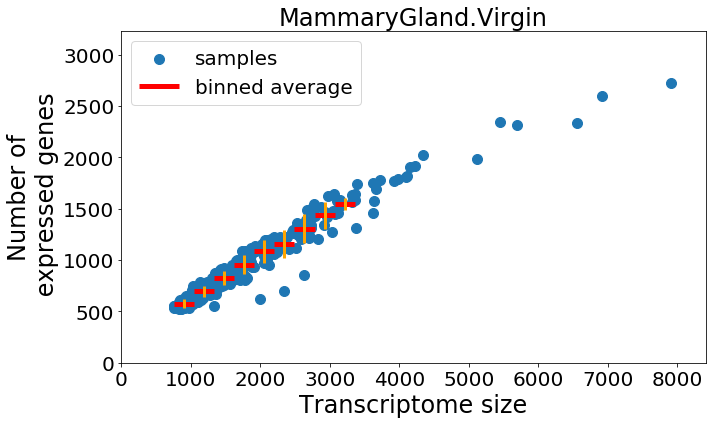

Handling 876 cells


GSM2906427_Liver1_dge.txt
['FetalLiver' 'Kidney' 'Liver']
saving
mazzolini
saving
null_model
saving


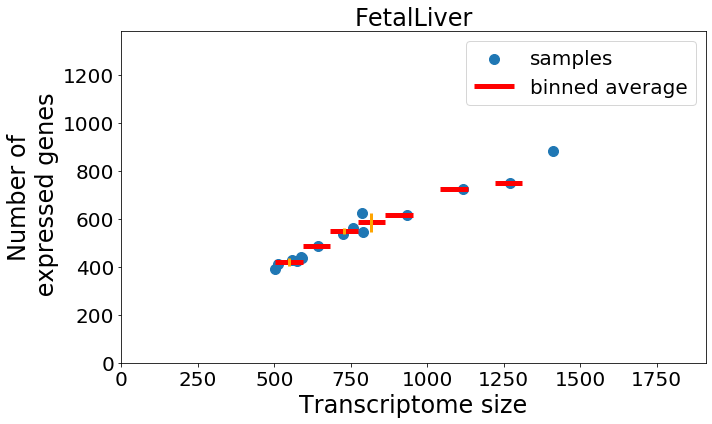

Handling 891 cells


saving
mazzolini
saving
null_model
saving


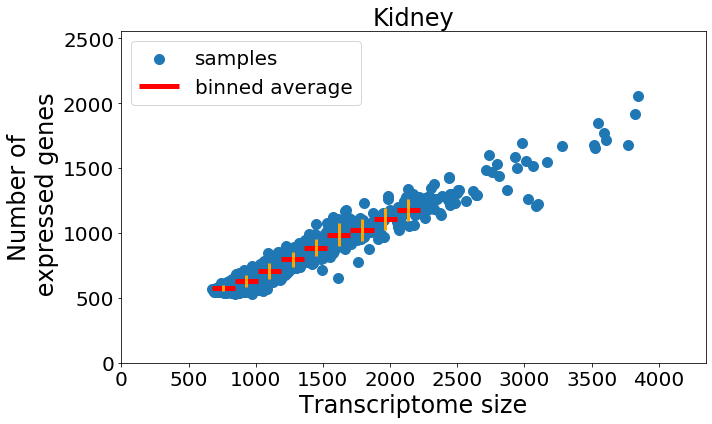

Handling 1958 cells


saving
mazzolini
saving
null_model
saving


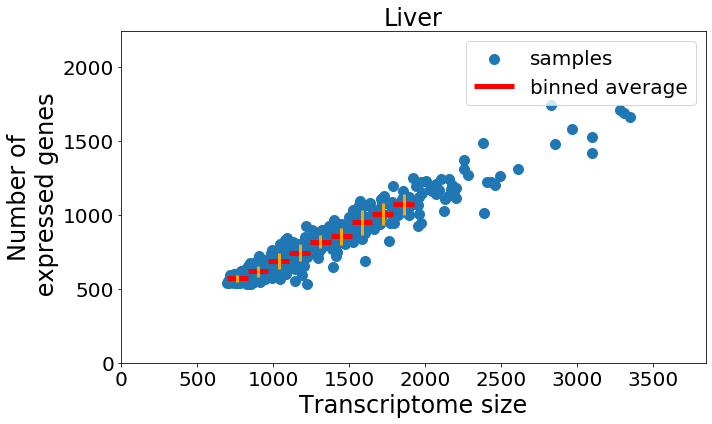

Handling 2832 cells


GSM2906477_TrophoblastStemCell_dge.txt
skipping GSM2906477_TrophoblastStemCell_dge.txt 

GSM2906466_PlacentaE14.2_dge.txt
['Placenta']
saving
mazzolini
saving
null_model
saving


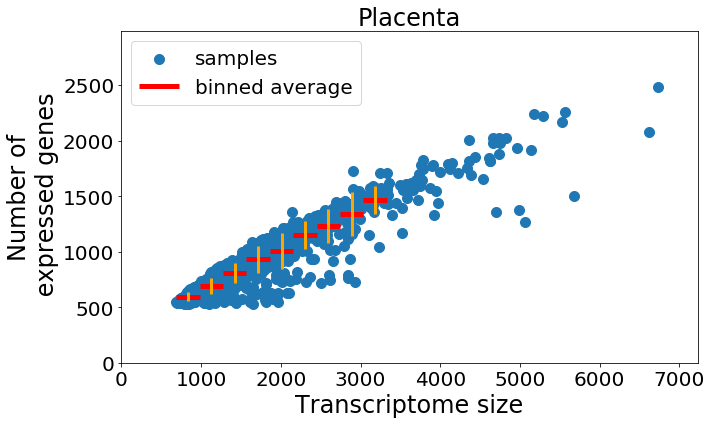

Handling 4112 cells


GSM2906421_FetalLiverE14.1_dge.txt
skipping GSM2906421_FetalLiverE14.1_dge.txt 

GSM2906472_Stomach_dge.txt
['FetalPancreas' 'FetalStomach' 'Stomach']
saving
mazzolini
saving
null_model
saving


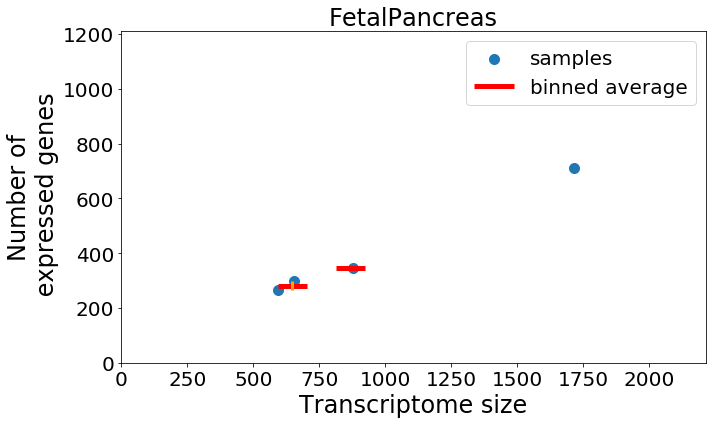

Handling 4116 cells


saving
mazzolini
saving
null_model
saving


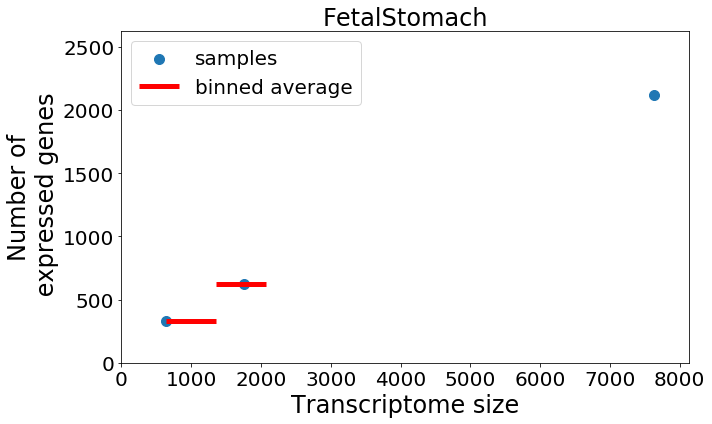

Handling 4119 cells


saving
mazzolini
saving
null_model
saving


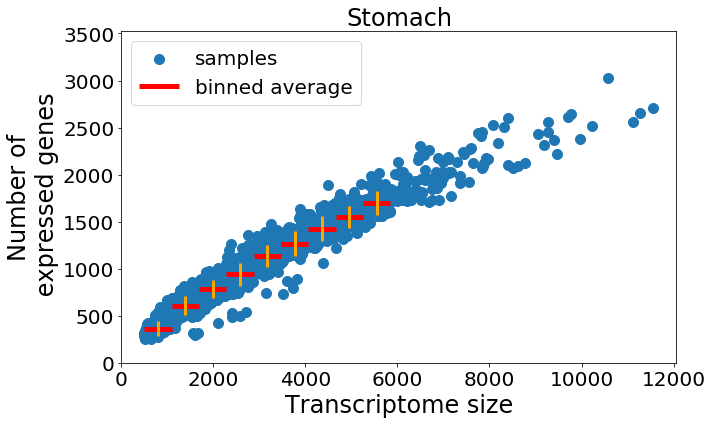

Handling 6175 cells


GSM2906464_PeripheralBlood6_dge.txt
['PeripheralBlood']
saving
mazzolini
saving
null_model
saving


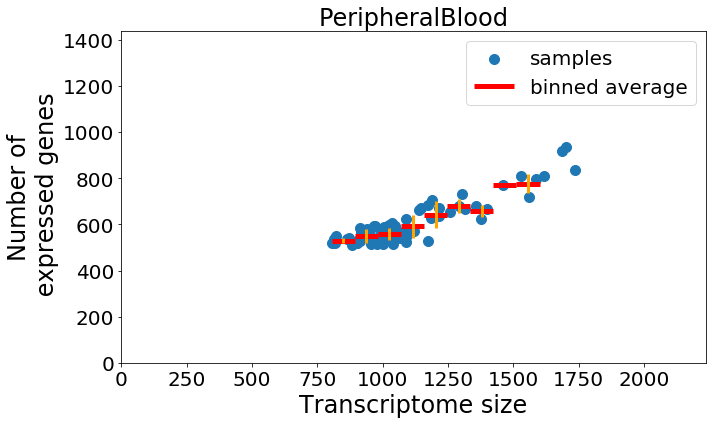

Handling 6247 cells


GSM2906461_PeripheralBlood3_dge.txt
['PeripheralBlood']


/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


saving
mazzolini
saving
null_model
saving


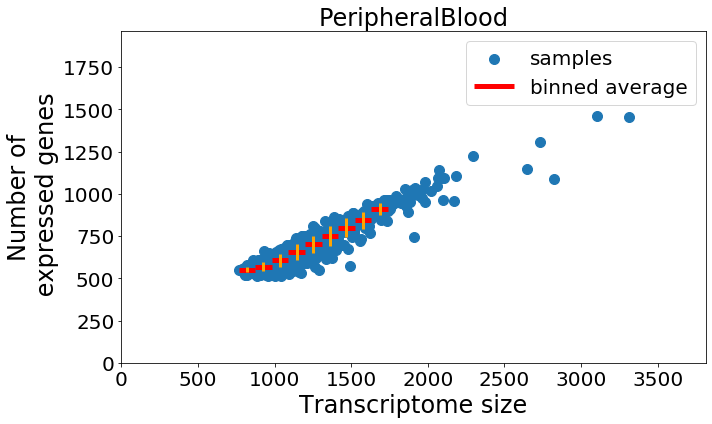

Handling 7147 cells


GSM2889483_MammaryGland.Involution1_dge.txt
['AdultMammaryGland.Involution']
saving
mazzolini
saving
null_model


In [ ]:
for file in files[1:]:
    print(file)
    data = pd.read_csv(f"data/{file}", sep=" ")
    data = data[data.columns[data.columns.isin(df_info['Cell_id'])]]
    
    if len(data.columns) < 1:
        print(f"skipping {file} \n")
        continue
    
    #tissues = df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']=='Adult')]['tissue'].unique()
    tissues = df_info[df_info['Cell_id'].isin(data.columns)]['tissue'].unique()

    print(tissues)
    if len(tissues) < 1:
        print(f"no tissue found \n")
        continue
    for tissue in tissues:
        df = data.reindex(columns=df_info[df_info['Cell_id'].isin(data.columns) & (df_info['tissue']==tissue)]['Cell_id'])
        if tissue in saved:
            df = df.transpose().append(pd.read_csv(f"mainTable_{tissue}.csv", index_col=0, header=0).transpose(), ignore_index=False).transpose().fillna(0)
        #df = df.divide(df.sum(0), 1).applymap(lambda cpm: np.log(cpm*1e6+1)) #log(cpm +1)
        A_sub = df.sum(axis=1)
        O_sub = df.apply(lambda x: len(x[x>0]), 1)
        M_sub = df.apply(np.sum, 0)
        diffWords_sub = df.apply(lambda x: len(x[x>0]), 0)
        
        if tissue in frac_of.keys():
            frac_of[tissue]['data'].add(A_sub, fill_value = 0)
            frac_of[tissue]['N']+=len(M_sub)
        else:
            frac_of[tissue] = {'data': A_sub,
                                  'N': len(M_sub)}

        A = A.add(A_sub, fill_value=0)
        O = O.add(O_sub, fill_value=0)
        M = M.append(M_sub)
        diffWords = diffWords.append(diffWords_sub)
        if tissue in n_genes.keys():
            n_genes[tissue] = n_genes[tissue].append(diffWords_sub)
        else:
            n_genes[tissue]= diffWords_sub
        
        gene_presence = gene_presence.add(df.apply(lambda x: len(x[~x.isna()]), 1), fill_value=0)
        gene_presence_nonnull_sub = df.apply(lambda x: len(x[~x.isna() & (x>0)]), 1).astype(int)
        gene_presence_nonnull = gene_presence_nonnull.add(gene_presence_nonnull_sub, fill_value=0).astype(int)
        var = var.add(df.apply(lambda x: (x*x).sum(), 1), fill_value=0)
        
        n_expressed_genes_sub = pd.Series(index=df.index, data=np.zeros_like(df.index))
        n_expressed_genes_sub[A_sub.sort_values(ascending=False).index[:100]]+=1
        n_expressed_genes = n_expressed_genes.add(n_expressed_genes_sub, fill_value=0)

        save_model(df,"data",tissue)
        mazzolini(M_sub, A_sub/A_sub.sum(), tissue)
        null_model(df, M_sub, A_sub/gene_presence_nonnull_sub)
        heaps(M_sub, diffWords_sub, tissue)
        saved.append(tissue)
        df.to_csv(f"mainTable_{tissue}.csv", index=True, header=True)
        print(f"Handling {len(M)} cells")

        del df 
        del A_sub
        del O_sub
        del M_sub
        del diffWords_sub
        del gene_presence_nonnull_sub
        gc.collect()
        print("\n")
    del tissues
    del data
    gc.collect()

means = A/gene_presence
means_nozero = A/gene_presence_nonnull
var = var/gene_presence - means*means
f = (A/A.sum())
O = O / gene_presence
O = O.reindex_like(means)
cv2 = var/means/means

In [ ]:
data = {
    'means': means,
    'var': var,
    'freq': f,
    'O': O,
    'M': M,
    'cv2': cv2,
    'diffWords': diffWords,
    'means_nonzero': means_nozero,
    'n_expressed': n_expressed_genes,
    'n_genes': n_genes,
    'frac_of': frac_of
}

with open("data.pkl","wb") as file:
    pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("data.pkl","rb") as file:
    data = pickle.load(file)

means = data['means']
var = data['var']
f = data['freq']
O = data['O']
M = data["M"]
cv2 = data['cv2']
diffWords = data['diffWords']
means_nozero = data['means_nonzero']
n_expressed_genes = data['n_expressed']
frac_of = data['frac_of']

In [ ]:
#A = df.sum(axis=1)
#f = A/A.sum()
#O=O/len(M)
#O = df.apply(lambda x: len(x[x>0])/float(len(x)), 1)
#M = df.apply(np.sum, 0)
#diffWords = df.apply(lambda x: len(x[x!=0]), 0)
#means = df.apply(np.average, 1)
#var = df.apply(np.var, 1)
#cv2 = var/means/means

In [ ]:
list(map(print,n_expressed_genes[n_expressed_genes>=2].sort_values(ascending=False).index[:100]))

# Fraction of trascriptome

In [ ]:
palette = itertools.cycle(sns.color_palette(palette="Set1", n_colors=100, desat=.9))

thresholded = {}

fig,ax = plt.subplots(figsize=(15,8))
for tissue in frac_of.keys():
    A_tissue = (frac_of[tissue]['data'] / frac_of[tissue]['N']).sort_values(ascending=False)
    A_tissue_sum = np.cumsum(A_tissue.values) / A_tissue.sum() #h thr
    ax.plot(A_tissue_sum, label = tissue, c=next(palette))
    thresholded[tissue] = A_tissue_sum[99]
    #thresholded[tissue] = np.argwhere(A_tissue_sum>=0.4).ravel()[0] #v thr
ax.set_xscale('log')
ax.set_xlim(1, 3e4)
ax.tick_params(labelsize=20)
ax.set_xlabel("Number of genes", fontsize=24)
ax.set_ylabel("Fraction of trascriptome\n described", fontsize=24)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
fig.savefig("fracof.pdf")

In [ ]:
gene_to_thr = pd.DataFrame(data= thresholded.items()).set_index(0).sort_values(1, ascending=False)

fig,ax = plt.subplots(figsize=(20,10))
ax.bar(gene_to_thr.index, gene_to_thr.values.ravel())
ax.tick_params(rotation=90)

ax.set_ylabel("Fraction of trascriptome\n described by 100 genes", fontsize=24)
#ax.set_ylabel("Number of genes\n to describe 40% of trascriptome", fontsize=24)

plt.tight_layout()
plt.show()
fig.savefig("frac_of_100genes.pdf")

In [ ]:
pd.DataFrame(index=gene_to_thr.sort_values(1).index, data=range(len(gene_to_thr)), columns=['MCA']).to_csv("trascriptome_sort.csv", index=True)

In [ ]:
df_sort = pd.read_csv("trascriptome_sort.csv", index_col=0).dropna(how='any', axis=0).astype(int)
df_sort['MCA'] = range(len(df_sort))
fig = plt.figure(figsize=(10,8))
plt.scatter(*df_sort.values.T, s=90)
plt.xlim(-1,15)
plt.ylim(-1,15)

plt.xlabel("MCA", fontsize=20)
plt.ylabel("tabula_muris", fontsize=20)
plt.show()

In [ ]:
for g in frac_of['MammaryGland.Lactation']['data'].sort_values(ascending=False).index[:10]:
    print(g)

## Box plot

In [ ]:
fig,ax=plt.subplots(figsize=(45,35))
organ_names=n_genes.keys()
n_genes_all=list(map(lambda organ: organ[1].values,n_genes.items()))
box1=plt.boxplot(np.array(n_genes_all), vert=True, patch_artist=True,notch=True,
        boxprops=dict(facecolor='magenta', color='magenta'))
ax.set_xticklabels(labels=organ_names,rotation=75)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=18)
plt.title('Number of genes detected per cell', fontsize=20)
plt.xlabel('Organ', fontsize=20)
plt.ylabel('N genes', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()
fig.savefig("boxplot.pdf")

# Null Model

In [ ]:
with open("data_null.pkl","rb") as file:
    data = pickle.load(file)

means_null = data['means']
var_null = data['var']
f_null = data['freq']
O_null = data['O']
M_null=data["M"]
cv2_null = data['cv2']
diffWords_null = data['diffWords']

# Zipf

In [ ]:
fig = plt.figure(figsize=(15,8))
x = np.arange(1, len(f))
plt.ylabel("$Frequency, f_i$", fontsize=24)
plt.xlabel("$RANK, i$", fontsize=24)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-7,1)
plt.plot(x, np.power(x,-0.9)*1e-1, 'g--', lw=2, label='$k*i^{-0.5}$')
plt.plot(np.sort(f.dropna())[::-1], c='blue', lw=5, label='Genes')
plt.plot(np.sort(f_null/f_null.sum())[::-1], c='orange', ls='--', lw=5, label='null_model')
plt.legend(fontsize=24)
plt.show()
fig.savefig("zipf.pdf")

In [ ]:
bins = 100
rang = (0-0.5/bins, 1+0.5/bins)
fig=plt.figure()
plt.hist(np.array(O.dropna(), dtype=float), histtype='step', lw=5, range = rang, color='blue', density=True, bins=bins)
plt.hist(np.array(O_null, dtype=float), histtype='step', lw=5, range = rang, bins=bins, color='orange', ls='--', density=True)
plt.xlabel("$o_i$", fontsize=24)
plt.ylabel("pdf", fontsize=24)
#plt.yscale('log')
#plt.xscale('log')
plt.show()
fig.savefig("U.pdf")

In [ ]:
bins = 15
rang = (0-0.5/bins, 1+0.5/bins)
fig=plt.figure()
plt.hist(np.array(O.dropna(), dtype=float), histtype='step', lw=5, range = rang, color='blue', density=True, bins=bins)
plt.hist(np.array(O_null, dtype=float), histtype='step', lw=5, range = rang, bins=bins, color='orange', ls='--', density=True)
plt.xlabel("$o_i$", fontsize=24)
plt.ylabel("pdf", fontsize=24)
plt.yscale('log')
#plt.xscale('log')
plt.show()
fig.savefig("U_log.pdf")

In [ ]:
fig, ax=plt.subplots()
O.hist(ax=ax, histtype='step', lw=5, color='blue', density=True)
#plt.hist(np.array(O_null, dtype=float), histtype='step', lw=5, range = rang, color='orange', ls='--', density=True)
plt.xlabel("$o_i$", fontsize=24)
plt.ylabel("pdf", fontsize=24)
#plt.yscale('log')
#plt.xscale('log')
plt.show()
fig.savefig("U_zoom.pdf")

In [ ]:
fig = plt.figure()
plt.hist(M, density=False, color='blue', bins = 15, label='files')
#plt.hist(M_null, density=False, color='orange', histtype='step', lw=4, ls='--', bins = 15, label='files')
plt.title("realization size distribution", fontsize = 24)
plt.xlabel("total counts per file", fontsize=24)
plt.ylabel("#", fontsize=24)
plt.legend(fontsize=24)
plt.show()
fig.savefig("M_distr.png")

In [ ]:
fig = plt.figure()
plt.hist(diffWords, density=False, color='blue', bins = 15, label = 'files')
plt.title("vocabulary size distribution", fontsize=18)
plt.xlabel("#different words per file", fontsize=16)
plt.ylabel("#", fontsize=16)
plt.legend(fontsize=18)
plt.show()
fig.savefig("gene_expr_distr.png")

## Heaps

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.scatter(M, diffWords, label='samples')
plt.scatter(M_null, diffWords_null, label='null_model')
plt.xlabel("Realization size", fontsize=24)
plt.ylabel("#different words", fontsize=24)
skip_bins = 15
n_bins=35
bin_means, bin_edges, binnumber = stats.binned_statistic(M, diffWords,statistic='mean', bins=np.linspace(M.min(),max(M), n_bins))
plt.hlines(bin_means[:-skip_bins], bin_edges[:-1][:-skip_bins], bin_edges[1:][:-skip_bins], colors='r', lw=5, label='binned average')
bin_stds, _, _ = stats.binned_statistic(M, diffWords,statistic='std', bins=np.linspace(M.min(),np.quantile(M, 0.9), n_bins))
plt.errorbar(((bin_edges[:-1]+bin_edges[1:])/2)[:-skip_bins],bin_means[:-skip_bins], bin_stds[:-skip_bins], fmt='none', ecolor='orange', elinewidth=3)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,max(M)*1.1)
plt.legend(fontsize=20)
plt.show()
fig.savefig("heaps.png")

In [ ]:
bin_vars = bin_stds*bin_stds
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(bin_means[:-skip_bins], bin_vars[:-skip_bins],s=90, label='')
ax.plot(bin_means[:-skip_bins], bin_means[:-skip_bins], label='Poisson')
ax.plot(bin_means[:-skip_bins], bin_means[:-skip_bins]**2, label='Taylor')
ax.set_xlabel("Heaps' mean", fontsize=24)
ax.set_ylabel("Heaps' var", fontsize=24)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=24)
#ax.set_ylim(1e3,3e4)
ax.set_xlim(np.nanmin(bin_means),np.nanmax(bin_means))
plt.show()
fig.savefig("heaps_Taylor.pdf")

# CV2

In [ ]:
means = means.dropna()
var = var.reindex_like(means)
O = O.reindex_like(means)

In [ ]:
fig, ax =plt.subplots(figsize=(15,8))
plotcv2mean(means.values, var.values, ax=ax, normalisation_str='counts')
fig.savefig("cvmean_loglog.pdf")

# Mean vs Occurrence

In [ ]:
fig=plt.figure(figsize=(10,8))
nfiles = len(M)
plt.scatter(O*nfiles, means, c='b', alpha=0.8, label='genes')
#plt.scatter(O_null*len(M_null), means_null*5, c='orange', alpha=0.8, label='genes')

x = x
plt.plot(x, x/(nfiles), lw=4, label='bound', c='cyan', ls='--')


bin_means, bin_edges, _ = stats.binned_statistic(O*nfiles, means, statistic='mean', bins=np.logspace(-3,6))
x = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(x,bin_means, marker='x', c='r', label='binned average')
plt.ylabel("$<counts>$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(counts)$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(means[means!=0].min()/5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+8000)
plt.legend(fontsize=20)
plt.show()
fig.savefig("mean_occ.pdf")

In [ ]:
fig=plt.figure(figsize=(10,8))
nfiles = len(M)
plt.scatter(O.reindex_like(means_nozero)*nfiles, means_nozero, c='b', alpha=0.8, label='genes')
#bin_means, bin_edges, _ = stats.binned_statistic(O.reindex_like(means_nozero)*nfiles, means_nozero, statistic='mean', bins=np.linspace(1,1e4,200))
#x = (bin_edges[1:]+bin_edges[:-1])/2
#plt.scatter(x,bin_means, marker='x', c='r', label='binned average')
plt.ylabel("$<counts(>0)>$", fontsize=16)
plt.xlabel("$\Sigma_j\Theta(counts)$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.5,np.power(10,np.log10(means.max())+1))
plt.xlim(5e-1,nfiles+10000)
plt.legend(fontsize=20)
plt.show()
fig.savefig("mean_occ_non_zero.pdf")

# Null model 1

In [ ]:
#%%timeit
rs = np.random.RandomState(seed=42)
f_null_1 = (means_nozero / means_nozero.sum()).dropna()
df_null_1 = pd.DataFrame(index=f_null_1.index)
for sample in M.index:
    if sample in df_null_1.columns:
        continue
    df_null_1.insert(0,sample,np.average(np.array([rs.multinomial(M[sample], f_null_1.astype(float).values) for _ in range(1)]), axis=0))
    gc.collect()
#f_null_1=df_null_1.astype(int)
df_null_1 = df_null_1.divide(df_null_1.sum(0),1).multiply(M[df_null_1.columns])
gc.collect()

In [ ]:
df_null_1 = df_null_1.dropna().transpose()
for g in df_null_1.columns:
    df_null_1[g][rs.choice(len(df_null_1.index), size=len(np.argwhere(df_null_1[g]==0).ravel()), replace=False)]=0
df_null_1 = df_null_1.transpose()
df_null_1 = df_null_1.divide(df_null_1.sum(0),1).multiply(M.drop_duplicates()[df_null_1.columns])
gc.collect()

In [ ]:
A_null_1 = df_null_1.mean(axis=1)
f_null_1 = A_null_1/A_null_1.sum()
O_null_1 = df_null_1.apply(lambda x: len(x[x>0])/float(len(x)), 1)
M_null_1 = df_null_1.apply(np.sum, 0)
diffWords_null_1 = df_null_1.apply(lambda x: len(x[x>0]), 0)
means_null_1 = df_null_1.apply(np.average, 1)
var_null_1 = df_null_1.apply(np.var, 1)
cv2_null_1 = var_null_1/means_null_1/means_null_1

In [ ]:
fig = plt.figure(figsize=(15,8))
x = np.arange(1, len(f))
plt.ylabel("$Frequency, f_i$", fontsize=24)
plt.xlabel("$RANK, i$", fontsize=24)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1e-7,1)
plt.plot(x, 1./x, 'g--', lw=2, label='$i^{-1}$')
plt.plot(np.sort(f.reindex_like(f_null_1))[::-1], c='blue', lw=8, label='Genes')
plt.plot(np.sort(f_null.reindex_like(f_null_1))[::-1], c='orange', ls='--', lw=6, label='null_model')
plt.plot(np.sort(f_null_1/f_null_1.sum())[::-1], c='green', ls=':', lw=5, label='null_model_1')
plt.legend(fontsize=24)
plt.show()
fig.savefig("zipf_null_0.pdf")

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.scatter(M, diffWords, label='samples')
plt.scatter(M_null, diffWords_null, label='null_model')
plt.scatter(M_null_1, diffWords_null_1, label='null_model_1')
plt.xlabel("Realization size", fontsize=24)
plt.ylabel("#different words", fontsize=24)
#bin_means, bin_edges, binnumber = stats.binned_statistic(M, diffWords,statistic='mean', bins=np.linspace(0,max(M)))
#plt.hlines(bin_means[:-15], bin_edges[:-1][:-15], bin_edges[1:][:-15], colors='r', lw=5, label='binned average')
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0,max(M)*1.1)
plt.legend(fontsize=20)
plt.show()
fig.savefig("heaps_null_o.pdf")

In [ ]:
fig, ax =plt.subplots(figsize=(15,8))
ax.scatter(means_null.reindex_like(means.drop_duplicates()), cv2_null.reindex_like(means.drop_duplicates()), c='orange', label='mazzolini')
ax.scatter(means_null_1.reindex_like(means.drop_duplicates()), cv2_null_1.reindex_like(means.drop_duplicates()), c='green', label='null model 0')
plotcv2mean(means.values, var.values, ax=ax, normalisation_str='counts')
fig.savefig("cvmean_loglog.pdf")